<span style="color: yellow; font-size: 1.5em; font-family: 'Times New Roman', Times, serif;">
This code was used in our submission to the 2022 Conference on Decision and Control (CDC)

    Paper Title:    "End-to-End Imitation Learning with Safety Guarantees using Control Barrier Functions"
    Authors:        Ryan K. Cosner, Yisong Yue, Aaron D. Ames
    Correspondent:  Ryan K. Cosner (rkcosner@caltech.edu), PhD candidate
    Usage:          Open Access. Free use. If you find this code useful please cite our paper. 
</span>

```python
from getpass import getuser
import numpy as np
from datetime import datetime
from cosner_utils.utils import *
from cosner_utils.ode_sim import *
from cosner_utils.plotting_utils import *
from cosner_utils.pendulum_visualizer import *
from torchvision.utils import save_image
from controllers import *
from ipMobileNetV2 import *
import torch
from tqdm import tqdm
import csv

- `from getpass import getuser`: Retrieves the username of the user running the script.
- `import numpy as np`: Fundamental package for numerical computations in Python.
- `from datetime import datetime`: Provides classes for manipulating dates and times.
- `from cosner_utils.utils import *`: Imports custom utility functions.
- `from cosner_utils.ode_sim import *`: Imports custom utilities for Ordinary Differential Equation (ODE) simulation.
- `from cosner_utils.plotting_utils import *`: Imports custom utilities for plotting.
- `from cosner_utils.pendulum_visualizer import *`: Imports custom utilities for visualizing the pendulum.
- `from torchvision.utils import save_image`: Utilities for saving images in PyTorch.
- `from controllers import *`: Imports various controller classes and functions.
- `from ipMobileNetV2 import *`: Imports the MobileNetV2 model for the inverted pendulum.
- `import torch`: PyTorch library for deep learning and tensor computations.
- `from tqdm import tqdm`: Progress bar library for loops.
- `import csv`: Module for reading and writing CSV files.


```python 
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

if __name__ == '__main__':
    printInfo()

    # Run Inverted Pendulum
    print("\nWould you like to run the inverted pendulum code?" )
    timestamp = getTimeStamp()

    flag = getUserInfo()
    if flag:

        # Create Pendulum 
        print("\tGenerating Pendulum")
        x0 = np.array([[-0.3], [0]])
        inverted_pendulum = InvertedPendulum(x0)
        ip = PendulumEnv()
        convert_tensor = transforms.ToTensor()
        data_output_path = createDataOutputFolder("inverted_pendulum", timestamp)

        # Load Inverted Pendulum Model
        print("\tLoading Learned Model")
        model_path = "./finalModel.pth"
        e2e_model = MobileNetV2(width_mult = 1, states = 1, vel_layer_width = 200)
        e2e_model.load_state_dict(torch.load(model_path))
        e2e_model.eval()
        def e2e_controller(x):
            theta = x[0,0]
            theta_dot = x[1,0]
            ip.state = np.array([np.sin(theta), np.cos(theta), theta_dot])
            ip.last_u = None
            frame = ip.render(mode="rgb_array")
            img = Image.fromarray(frame)
            img = preprocess(img)
            save_image(img, "current_img.png")
            img_gen = Image.open("current_img.png")
            img_gen = convert_tensor(img_gen)
            theta_dot = torch.tensor([theta_dot], dtype=torch.float32).unsqueeze(0)
            u = e2e_model(img_gen.unsqueeze(0), theta_dot)
            u = u.cpu().detach().numpy()
            return u, True


<span style="font-family: 'Times New Roman', Times, serif;">
This section of the code begins by setting the environment variable `KMP_DUPLICATE_LIB_OK` to 'TRUE' <br>
to handle potential issues with parallel processing libraries. It then enters the main execution block, <br>
indicated by `if __name__ == '__main__':`. The `printInfo()` function is called to display relevant information. <br>

The code proceeds to interact with the user, asking if they want to run the inverted pendulum code. <br>
If the user consents (`flag = getUserInfo()`), it initializes the inverted pendulum system. <br>
The pendulum is generated with an initial state `x0` of `[-0.3, 0]`, and <br>
the `InvertedPendulum` and `PendulumEnv` classes are instantiated.<br> 
The data output folder is created with a timestamp for organization. <br>

Next, the pre-trained MobileNetV2 model is loaded from the file `finalModel.pth`. This model is used to implement the end-to-end controller for the inverted pendulum. The `e2e_controller` function is defined to process the state of the pendulum (`theta` and `theta_dot`), render the pendulum environment, preprocess the image, and use the MobileNetV2 model to predict the control input `u`. The predicted control input is then returned for use in controlling the pendulum.
</span>


```python 

        print("\nWould you like to run the inverted pendulum simulation for a single initial condition? ")
        flag = getUserInfo()
        if flag:
            # Run IP Simulation
            controllers = [0, 1, 2]
            for c in controllers: 
                if c == 0: 
                    print("\nWould you like to use the nominal controller? ")
                    flag = getUserInfo()
                    path_suffix = "_nominal"
                    inverted_pendulum.controller = inverted_pendulum.controllerDes
                elif c == 1: 
                    print("\nWould you like to use the TR-OP controller? ")
                    flag = getUserInfo()
                    path_suffix = "_trop"
                    inverted_pendulum.controller = inverted_pendulum.trop
                elif c == 2: 
                    print("\nWould you like to use the end-to-end learned controller? ")
                    flag = getUserInfo()       
                    path_suffix = "_learned"    
                    inverted_pendulum.controller = e2e_controller
       

                if flag: 
                    inverted_pendulum.tend = 2
                    inverted_pendulum.simulate()
                    inverted_pendulum.moduloSpin()
                    inverted_pendulum.plot(data_output_path + path_suffix)
                    inverted_pendulum.plotPlanar(data_output_path + path_suffix)
                    inverted_pendulum.saveData(data_output_path + path_suffix)
                else: 
                    continue

<span style="font-family: 'Times New Roman', Times, serif;">
The provided code segment interacts with the user to determine if they would like to run <br> 
the inverted pendulum simulation for a single initial condition. If the user agrees   <br> 
(`flag = getUserInfo()`), the code initializes an array of controllers (`controllers = [0, 1, 2]`) and iterates over them.  <br> 

For each controller, the code checks which type of controller the user wants to use:  <br> 
- If `c == 0`, it asks the user if they want to use the nominal controller (`controllerDes`),  <br> 
 sets the path suffix to `_nominal`, and assigns the nominal controller to the inverted pendulum.  <br> 
- If `c == 1`, it asks the user if they want to use the TR-OP controller, sets the path suffix to
 `_trop`, and assigns the TR-OP controller to the inverted pendulum. <br> 
- If `c == 2`, it asks the user if they want to use the end-to-end learned  <br> 
controller, sets the path suffix to `_learned`, and assigns the end-to-end
 controller to the inverted pendulum.  <br> 

If the user agrees to use a specific controller, the code sets the simulation  <br> 
 end time (`tend`) to 2 seconds and runs the simulation. After the simulation,  <br> 
 it processes the pendulum's state using `moduloSpin()`, plots the results using  <br> 
  `plot()` and `plotPlanar()`, and saves the data to the specified path.  <br> 

If the user does not agree to use the specific controller, the loop continues to the next controller.  <br> 
</span>


```python 

      # Create Inverted Pendulum Data Set
        if True:
            c = np.sqrt(3)*(45*pi/180)**2 # 45 degrees
            x_min = -45/180*pi-0.1765
            x_max = -x_min
            x_now = x_min
            x = []
            y = []

            r = 0.009

            x_last = x_now
            y_last =  (-2*x_now+np.sqrt(4*np.sqrt(3)*(c - np.sqrt(3)*x_now**2) + 4*x_now**2))/2/np.sqrt(3)
            x.append(x_last)
            y.append(y_last)
            rs = []
            i = 0
            while x_now < x_max:
                y_now =  (-2*x_now+np.sqrt(4*np.sqrt(3)*(c - np.sqrt(3)*x_now**2) + 4*x_now**2))/2/np.sqrt(3)

                if ((x_now-x_last)**2 + (y_now-y_last)**2) > r**2:
                    x.append(x_now)
                    y.append(y_now)
                    rs.append(np.sqrt((x_now-x_last)**2 + (y_now-y_last)**2))
                    x_last = x_now
                    y_last = y_now
                x_now += 0.00005
                i+=1

            x = np.array(x)
            x = np.hstack([x,-x])
            y_bottom = -np.array(y)
            y = np.hstack([y,y_bottom])

            plt.figure()
            plt.plot(x,y, '.')
            plt.show()
            # Visualize
            path = "./data/trainingData/training_set_r_" + str(max(rs))
            os.system("mkdir " + path )
            for i in range(len(x)):
                theta = x[i]
                ip.state = np.array([np.sin(theta), np.cos(theta), y[i]])
                ip.last_u = None
                frame = ip.render(mode="rgb_array")
                img = Image.fromarray(frame)
                img = preprocess(img)
                save_image(img, path + "/img_"+ str(i).zfill(4) + ".png")

            os.system("mkdir " + path + "/csv")
            with open(path + "/csv/data.csv", "w", newline="\n") as csvfile:
                fieldnames = ["i", "theta", "theta_dot", "u"]
                writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
                writer.writeheader()
                for i in range(len(x)):
                    theta = x[i]
                    theta_dot = y[i]
                    state = np.array([[theta], [theta_dot]])
                    u = inverted_pendulum.trop(state)
                    writer.writerow({"i": str(i).zfill(4), "theta": x[i], "theta_dot": y[i], "u": u[0,0]})

<span style="font-family: 'Times New Roman', Times, serif;">
The provided code segment creates a dataset for the inverted pendulum. Here’s a detailed explanation of each step:

1. **Initialization**:
   - The constant `c` is calculated as \(\sqrt{3} \times \left(\frac{45 \times \pi}{180}\right)^2\), representing a 45-degree angle.
   - `x_min` and `x_max` define the range for the angle \(\theta\), offset slightly for the initial conditions.
   - `x_now` is initialized to `x_min`, and empty lists `x` and `y` are created to store the angle and angular velocity data points.
   - `r` is a small radius value used for checking the distance between points.

2. **Initial Points**:
   - The first point (`x_last`, `y_last`) is calculated and added to the lists `x` and `y`.

3. **Generating Points**:
   - A while loop generates points within the range `[x_min, x_max]`. For each `x_now` value, `y_now` is calculated using a given formula.
   - The distance between the current point (`x_now`, `y_now`) and the last point (`x_last`, `y_last`) is checked. If it exceeds `r`, the point is added to the lists, and `x_last` and `y_last` are updated.
   - `x_now` is incremented by a small value (0.00005) in each iteration to generate the next point.

4. **Symmetry**:
   - The lists `x` and `y` are converted to numpy arrays. `x` is mirrored to create symmetrical data around zero, and `y` is mirrored to create a bottom half.

5. **Visualization**:
   - The generated points are plotted to visualize the dataset.

6. **Saving Images**:
   - A directory path for storing the training data is created.
   - For each point in the dataset, the pendulum’s state is set, and an image of the pendulum is rendered and saved to the specified directory.

7. **Saving Data**:
   - A CSV file is created in the specified directory to store the dataset.
   - For each point, the state (`theta`, `theta_dot`) and control input `u` are calculated and written to the CSV file.

Overall, this code segment generates a comprehensive dataset of images and corresponding states for training or evaluating the inverted pendulum model.
</span>


```python 

            # compare results
            if True:

                def e2e_controller(x):
                    theta = x[0,0]
                    theta_dot = x[1,0]
                    ip.state = np.array([np.sin(theta), np.cos(theta), theta_dot])
                    ip.last_u = None
                    frame = ip.render(mode="rgb_array")
                    img = Image.fromarray(frame)
                    img = preprocess(img)
                    save_image(img, "current_img.png")

                    img_gen = Image.open("current_img.png")
                    img_gen = convert_tensor(img_gen)

                    theta_dot = torch.tensor([theta_dot], dtype=torch.float32).unsqueeze(0)
                    u = e2e_model(img_gen.unsqueeze(0), theta_dot)
                    u = u.cpu().detach().numpy()
                    return u


                err = []
                ues = []
                uls = []

                for i in range(len(x)):
                    state = np.array([[x[i]], [y[i]]])
                    ue = inverted_pendulum.trop(state)
                    ul = e2e_controller(state)

                    ues.append(ue[0,0])
                    uls.append(ul[0,0])

                plt.figure()
                plt.plot(ues)
                plt.plot(uls)
                plt.show()

<span style="font-family: 'Times New Roman', Times, serif;">
This section of the code is responsible for comparing the results of the TR-OP controller and the end-to-end learned controller for the inverted pendulum. Here's a detailed explanation:

1. **Redefining the End-to-End Controller**:
   - The `e2e_controller` function is redefined to process the state of the pendulum (`theta` and `theta_dot`), render the pendulum environment, preprocess the image, and use the MobileNetV2 model to predict the control input `u`. The control input is then returned.

2. **Initializing Lists**:
   - Three empty lists `err`, `ues`, and `uls` are initialized to store the errors and control inputs from the TR-OP and end-to-end learned controllers.

3. **Iterating Through Data Points**:
   - A for loop iterates through all the data points in the dataset (`x` and `y` values).
   - For each point, the state is defined as a numpy array with `theta` and `theta_dot`.

4. **Calculating Control Inputs**:
   - The control input `ue` is calculated using the TR-OP controller (`inverted_pendulum.trop`).
   - The control input `ul` is calculated using the end-to-end learned controller (`e2e_controller`).

5. **Storing Control Inputs**:
   - The control inputs `ue` and `ul` are appended to their respective lists `ues` and `uls`.

6. **Plotting the Results**:
   - A new figure is created, and the control inputs from the TR-OP controller (`ues`) and the end-to-end learned controller (`uls`) are plotted.
   - The plot is displayed to visualize the comparison between the two controllers.

This code segment effectively compares the performance of the two controllers by plotting their respective control inputs for each data point in the dataset.
</span>


```python 
# Test Inverted Pendulum
        if True:


            convert_tensor = transforms.ToTensor()


            def e2e_controller(x):
                theta = x[0]
                theta_dot = x[1]
                print("angle =", theta * 180 / pi)
                ip.state = np.array([np.sin(theta), np.cos(theta), theta_dot])
                ip.last_u = None
                frame = ip.render(mode="rgb_array")
                img = Image.fromarray(frame)
                img = preprocess(img)
                # save_image(img, "current_img.png")
                #
                # img = Image.open("current_img.png")
                # img = convert_tensor(img)
                theta_dot = torch.tensor([theta_dot], dtype=torch.float32)
                u = e2e_model(img.unsqueeze(0), theta_dot)
                u = u.cpu().detach().numpy()
                # print("input = ", u)
                return u

            inverted_pendulum.controller = e2e_controller
            inverted_pendulum.tend = 5
            inverted_pendulum.dt = 0.01
            inverted_pendulum.simulate = inverted_pendulum.simulateEulerStep
            inverted_pendulum.simulate()
            inverted_pendulum.moduloSpin()
            inverted_pendulum.plot(data_output_path)
            inverted_pendulum.plotPlanar(data_output_path)
            inverted_pendulum.saveData(data_output_path)

<span style="font-family: 'Times New Roman', Times, serif;">
This section of the code is responsible for testing the inverted pendulum using the end-to-end learned controller. Here’s a detailed explanation:

1. **Test Condition**:
   - The code block is executed unconditionally as it is wrapped in `if True:`.

2. **Tensor Conversion**:
   - The `convert_tensor` function from the `transforms` module is assigned to convert images to tensors.

3. **End-to-End Controller Definition**:
   - The `e2e_controller` function is defined to process the state of the pendulum (`theta` and `theta_dot`).
   - It prints the current angle in degrees.
   - It sets the pendulum state using `ip.state`.
   - It renders the pendulum environment to get an image frame and preprocesses the image.
   - The image tensor is created from the preprocessed image.
   - The `theta_dot` value is converted to a tensor.
   - The MobileNetV2 model is used to predict the control input `u` from the image tensor and `theta_dot`.
   - The control input `u` is returned as a numpy array.

4. **Setting the Controller**:
   - The `inverted_pendulum.controller` is set to the `e2e_controller`.

5. **Simulation Parameters**:
   - The simulation end time `tend` is set to 5 seconds.
   - The time step `dt` is set to 0.01 seconds.
   - The simulation method is set to `simulateEulerStep`.

6. **Running the Simulation**:
   - The pendulum simulation is run using the `simulate()` method.
   - The pendulum state is processed using `moduloSpin()`.
   - The simulation results are plotted using `plot()` and `plotPlanar()` methods.
   - The simulation data is saved to the specified data output path using `saveData()`.

This code segment tests the performance of the end-to-end learned controller by running a simulation of the inverted pendulum and visualizing the results.
</span>


<span style="color: yellow; font-size: 1.5em; font-family: 'Times New Roman', Times, serif;">
For different Initial conditions <br>
sim_many_ics.py
</span>

```python 
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

def printInfo(timestamp):
    print("Hi!")
    print("Running the CDC 2022 script with datetime label :", timestamp)

**Purpose**: This line sets an environment variable to avoid issues with parallel processing libraries. <br>

**Explanation**: The environment variable `KMP_DUPLICATE_LIB_OK` is set to `'TRUE'`. <br>
 This setting can be useful when using Intel's Math Kernel Library (MKL) for parallel processing, <br>
  as it allows the program to bypass certain errors related to loading multiple instances of the library. <br>


```python
    def e2e_controller(x):
        theta = x[0, 0]
        theta_dot = x[1, 0]
        ip.state = np.array([np.sin(theta), np.cos(theta), theta_dot])
        ip.last_u = None
        frame = ip.render(mode="rgb_array")
        img = Image.fromarray(frame)
        img = preprocess(img)
        save_image(img, "current_img.png")

        img_gen = Image.open("current_img.png")
        img_gen = convert_tensor(img_gen)

        theta_dot = torch.tensor([theta_dot], dtype=torch.float32).unsqueeze(0)
        u = e2e_model(img_gen.unsqueeze(0), theta_dot)
        u = u.cpu().detach().numpy()
        return u

    test.controller = test.trop#e2e_controller #test.trop#
    test.tend = 1
    test.dt = 0.01
    test.simulate = test.simulateEulerStep

    xs = np.linspace(-1,1,13)
    ys = np.linspace(-1,1,13)


    # Get ellipse
    ex, ey = getEllipse()

**Purpose**: The `e2e_controller` function processes the state of the pendulum, <br>
renders its environment, preprocesses the resulting image, and uses <br>
 a neural network model (MobileNetV2) to predict the control input. <br>

**Explanation**:

**e2e_controller Function**:

- **Input**: Takes the state `x` of the pendulum, where `x[0, 0]` is the angle `theta` and `x[1, 0]` is the angular velocity `theta_dot`.
- **State Setting**: Sets the pendulum's state in the environment using `ip.state` with the values of `sin(theta)`, `cos(theta)`, and `theta_dot`.
- **Reset Control Input**: Resets the last control input with `ip.last_u = None`.
- **Render Environment**: Renders the pendulum environment to get an image frame, which is then converted to a PIL image.
- **Preprocess Image**: The image is preprocessed and saved as `current_img.png`.
- **Load and Convert Image**: Loads the saved image and converts it to a tensor using `convert_tensor`.
- **Predict Control Input**: Converts `theta_dot` to a tensor and uses the MobileNetV2 model (`e2e_model`) to predict the control input `u`.
- **Return Control Input**: The control input `u` is returned as a numpy array.

**Testing Setup**:

- **Controller Assignment**: The controller for the test is set to `test.trop`. The `e2e_controller` can be used by uncommenting the relevant line.
- **Simulation Parameters**: The end time `tend` is set to 1 second, the time step `dt` is set to 0.01 seconds, and the simulation method is set to `simulateEulerStep`.

**Generate Grid Points**:

- **X and Y Values**: Generates linearly spaced values for `x` and `y` in the range `[-1, 1]` with 13 points each using `np.linspace`.

**Ellipse Data**:

- **Get Ellipse Points**: Calls the `getEllipse` function to obtain the x (`ex`) and y (`ey`) coordinates of an ellipse.


   ```python 
    iter = 0
    for x in xs:
        for y in ys:
            if test.getSafetyVal(np.array([[x],[y]]))>=0:
                os.system("mkdir " + data_output_path +"/ic" + str(iter))
                x0 = np.array([[x], [y]])
                test.x0 = x0
                test.reset()
                test.simulate()
                test.moduloSpin()
                test.plotPlanar(data_output_path+"/ic" + str(iter), ex, ey,plot=False)
                test.saveData(data_output_path+"/ic" + str(iter))

                iter +=1

**Purpose**: This loop iterates through different initial conditions, runs the simulation for each condition, and saves the results.

**Explanation**:

- **Initialization**: The `iter` variable is initialized to 0, which will be used to keep track of the number of iterations and name the directories for saving data.
- **Iterate through xs and ys**: Nested loops iterate through all combinations of `x` and `y` values in `xs` and `ys`, respectively.
- **Safety Check**: For each combination, the safety value is checked using `test.getSafetyVal()`. If the safety value is greater than or equal to 0, the initial condition is considered safe.
- **Create Directory**: A new directory is created for each safe initial condition using `os.system("mkdir " + data_output_path + "/ic" + str(iter))`.
- **Set Initial Condition**: The initial condition `x0` is set to the current `x` and `y` values.
- **Reset Test**: The `test` object is reset to its initial state using `test.reset()`.
- **Run Simulation**: The simulation is run using `test.simulate()`.
- **Process Results**: The results of the simulation are processed using `test.moduloSpin()`.
- **Plot Results**: The planar plot of the results is created using `test.plotPlanar()`. The `plot` parameter is set to `False` to disable plotting during the loop.
- **Save Data**: The simulation data is saved to the specified directory using `test.saveData()`.
- **Increment Iterator**: The `iter` variable is incremented by 1 to move to the next initial condition.


<span style="color: yellow; font-size: 1.5em; font-family: 'Times New Roman', Times, serif;">
USC example 
</span>

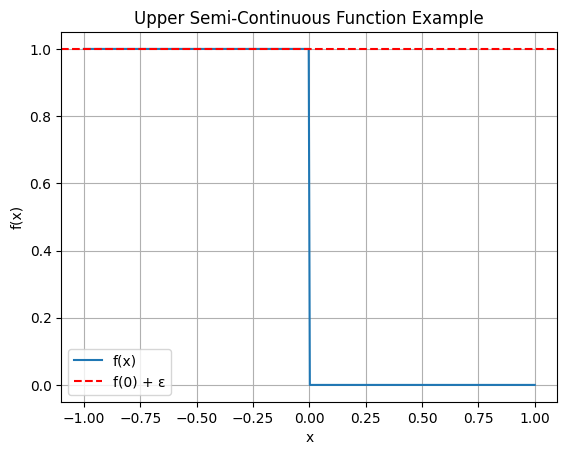

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Define the function
def f(x):
    return np.where(x <= 0, 1, 0)

# Generate data points
x = np.linspace(-1, 1, 400)
y = f(x)

# Plot the function
plt.plot(x, y, label='f(x)')
plt.axhline(y=1, color='r', linestyle='--', label='f(0) + ε')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('Upper Semi-Continuous Function Example')
plt.legend()
plt.grid(True)
plt.show()


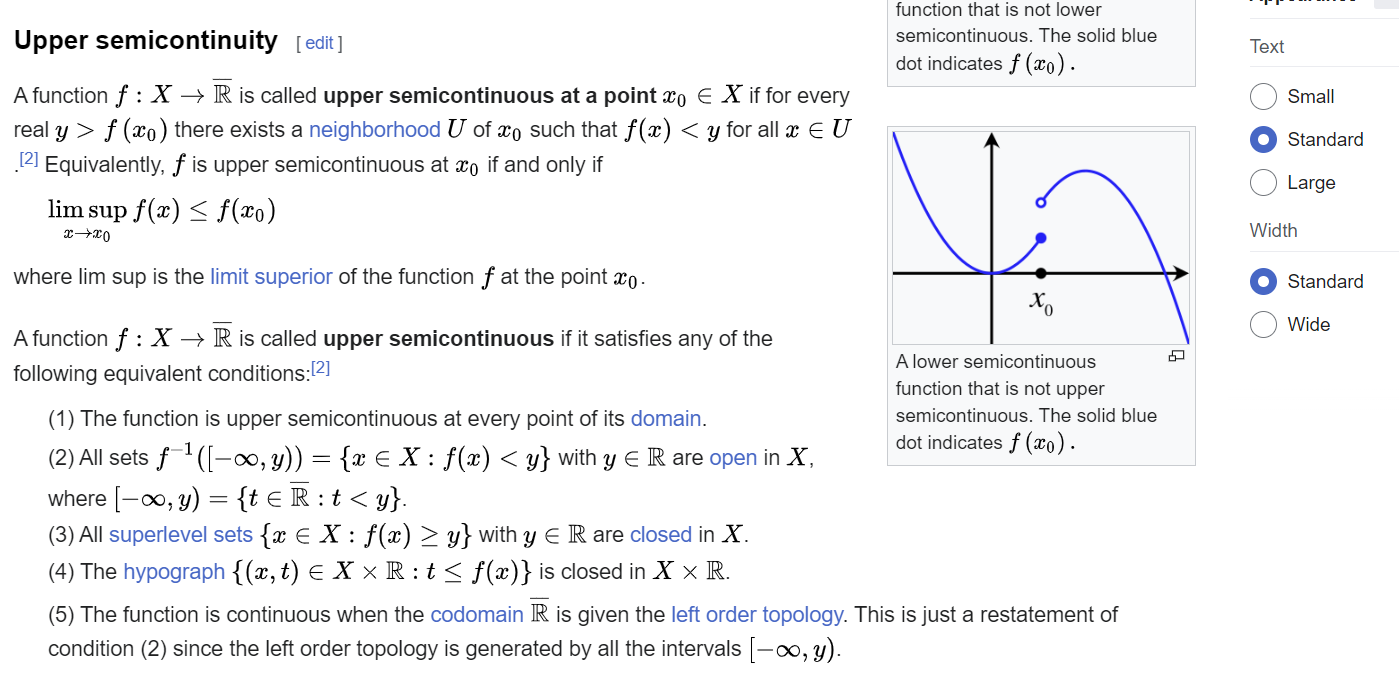

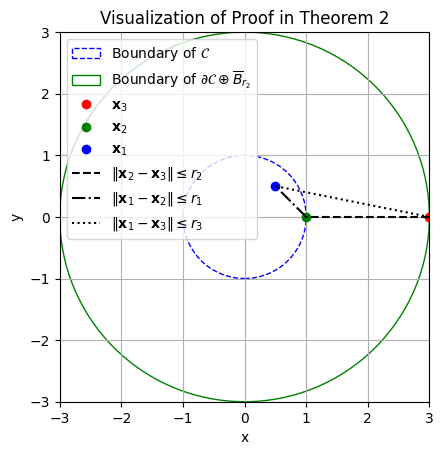

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Define radii
r1 = 1
r2 = 2
r3 = r1 + r2

# Define the circles
circle_c = plt.Circle((0, 0), r1, color='blue', fill=False, linestyle='--', label='Boundary of $\mathcal{C}$')
circle_c_delta = plt.Circle((0, 0), r3, color='green', fill=False, linestyle='-', label='Boundary of $\partial \mathcal{C} \oplus \overline{B}_{r_2}$')

# Define points
x3 = np.array([r3, 0])  # Point on the boundary of expanded safe set
x2 = np.array([r1, 0])  # Point on the boundary of original safe set within r2 of x3
x1 = np.array([0.5, 0.5])  # Point within the set D within r1 of x2

# Create the plot
fig, ax = plt.subplots()

# Add circles to plot
ax.add_patch(circle_c)
ax.add_patch(circle_c_delta)

# Plot points
ax.plot(*x3, 'ro', label='$\mathbf{x}_3$')
ax.plot(*x2, 'go', label='$\mathbf{x}_2$')
ax.plot(*x1, 'bo', label='$\mathbf{x}_1$')

# Draw lines showing distances
plt.plot([x3[0], x2[0]], [x3[1], x2[1]], 'k--', label='$\|\mathbf{x}_2 - \mathbf{x}_3\| \leq r_2$')
plt.plot([x2[0], x1[0]], [x2[1], x1[1]], 'k-.', label='$\|\mathbf{x}_1 - \mathbf{x}_2\| \leq r_1$')
plt.plot([x3[0], x1[0]], [x3[1], x1[1]], 'k:', label='$\|\mathbf{x}_1 - \mathbf{x}_3\| \leq r_3$')

# Set limits and labels
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
ax.set_aspect('equal')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title('Visualization of Proof in Theorem 2')

# Show the plot
plt.grid(True)
plt.show()
